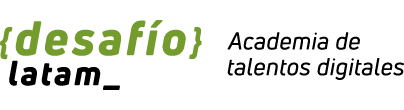

#<center><font color = 'green'>Solución desafío - Modelos de ensamble (parte I)</font></center>

1. Importa las librerías necesarias y la base de datos, y realiza un análisis por variable usando visualizaciones. Debes considerar las posibles correlaciones y representarlas en un heatmap.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

In [2]:
df = pd.read_csv('telecom_churn.csv')
print(df.shape)
df.sample(10)


(3333, 11)


Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  \
37        0            78                1         0       0.00   
3041      0            39                1         0       0.00   
1855      0            67                1         0       0.00   
77        1           144                1         0       0.21   
3065      0           122                1         1       2.27   
2606      1           145                1         0       0.00   
3321      0            60                1         0       0.00   
493       0           129                1         1       1.59   
1191      0           146                0         0       0.00   
2816      1           130                1         0       0.00   

      CustServCalls  DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
37                1    130.8        64           42.0       11.19      10.0  
3041              0     93.3        83           33.0        9.98       6.5  
1855              2    109.1       134           31.0        7.12      10.9  
77                4     61.6       117           20.1        3.86       8.2  
3065              3    195.4        83           79.7       13.41       8.4  
2606              1    224.2        89           65.0       15.75      16.1  
3321              3    193.9       118           41.0        4.25      13.2  
493               2    119.6       104           60.9       13.94       5.9  
1191              2    160.1        63           45.0       10.42       9.2  
2816              1    263.7       113           61.0        9.33      18.3

In [3]:
# búsqueda de valores ausentes
[(x1, np.sum(x2.isnull())) for x1, x2 in df.items()]


[('Churn', 0),
 ('AccountWeeks', 0),
 ('ContractRenewal', 0),
 ('DataPlan', 0),
 ('DataUsage', 0),
 ('CustServCalls', 0),
 ('DayMins', 0),
 ('DayCalls', 0),
 ('MonthlyCharge', 0),
 ('OverageFee', 0),
 ('RoamMins', 0)]

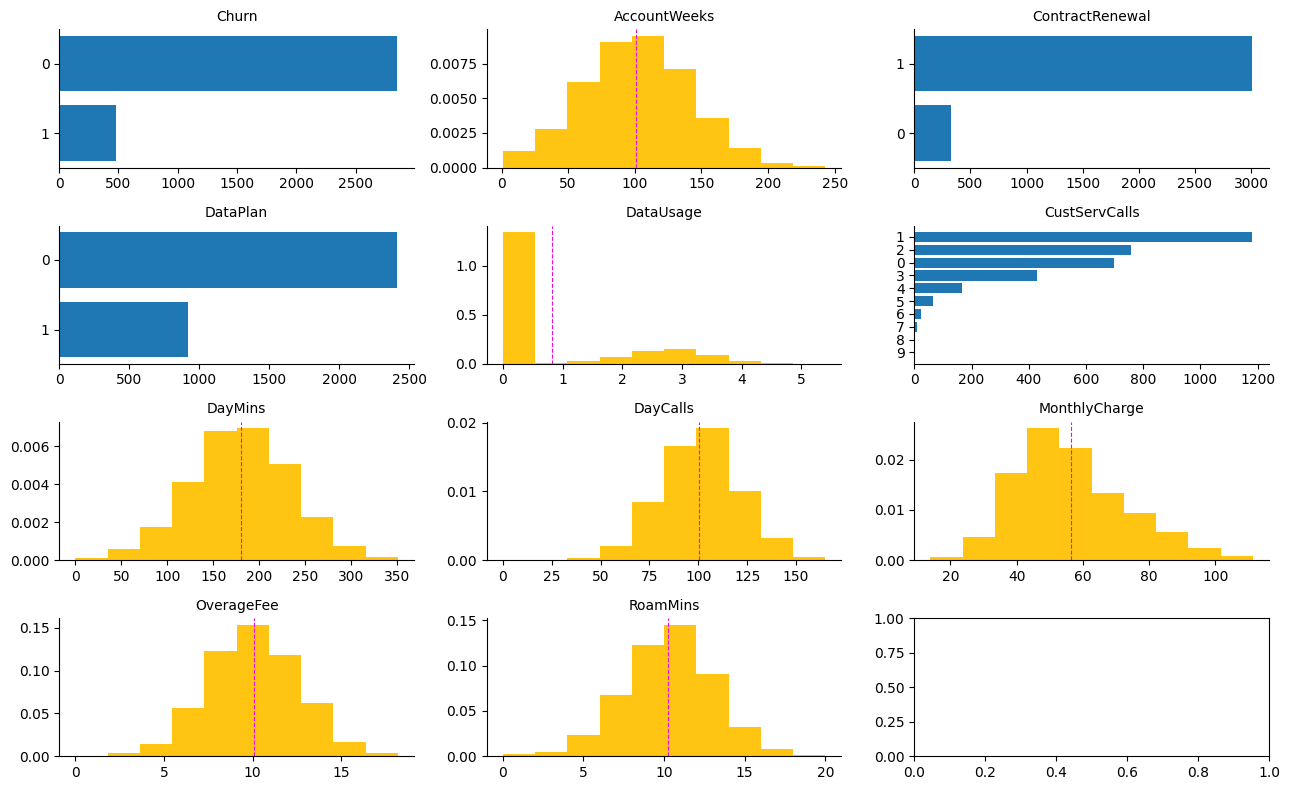

In [4]:
def plot_descriptive(df, ncols=3, max_discrete=12, figsize=(13, 6),
                     plot_type='hist', target='', fontsize=10):
    '''
    plot_type: acepta valores in ['hist', 'boxplot']
    '''
    nrows = df.shape[1]//ncols
    if nrows*ncols < df.shape[1]:
        nrows += 1

    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)

    i = 0
    for idx, (colname, serie)  in enumerate(df.items()):
        j = (idx % ncols)
        ax[i,j].set_title(colname, fontsize=fontsize)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)

        if (serie.dtype == 'object') or (
            serie.dtype == 'int64' and serie.unique().shape[0] <= max_discrete):
            serie = serie.value_counts().sort_values(ascending=True)

            ax_aux = ax[i,j].barh(
                y=np.array(serie.index).astype('str'),
                    width=serie.values,
            )
        else:
            if plot_type == 'hist':
                ax[i,j].hist(x=serie, color='xkcd:sunflower', density=True)
                ax[i,j].axvline(x=np.mean(serie), color='xkcd:fuchsia', ls='--', lw=0.8)
            elif plot_type == 'boxplot':
                ax[i,j].boxplot(serie)
                ax[i,j].set_xticklabels([''])

        if (j == ncols-1): i += 1

    plt.tight_layout()
    plt.show()

plot_descriptive(df, figsize=(13, 8))

In [5]:
print(df['Churn'].value_counts('%'))

print()
print(df['ContractRenewal'].value_counts('%'))
print()
print(df['DataPlan'].value_counts('%'))

df.describe()


0    0.855086
1    0.144914
Name: Churn, dtype: float64

1    0.90309
0    0.09691
Name: ContractRenewal, dtype: float64

0    0.723372
1    0.276628
Name: DataPlan, dtype: float64


Churn  AccountWeeks  ContractRenewal     DataPlan    DataUsage  \
count  3333.000000   3333.000000      3333.000000  3333.000000  3333.000000   
mean      0.144914    101.064806         0.903090     0.276628     0.816475   
std       0.352067     39.822106         0.295879     0.447398     1.272668   
min       0.000000      1.000000         0.000000     0.000000     0.000000   
25%       0.000000     74.000000         1.000000     0.000000     0.000000   
50%       0.000000    101.000000         1.000000     0.000000     0.000000   
75%       0.000000    127.000000         1.000000     1.000000     1.780000   
max       1.000000    243.000000         1.000000     1.000000     5.400000   

       CustServCalls      DayMins     DayCalls  MonthlyCharge   OverageFee  \
count    3333.000000  3333.000000  3333.000000    3333.000000  3333.000000   
mean        1.562856   179.775098   100.435644      56.305161    10.051488   
std         1.315491    54.467389    20.069084      16.426032     2.535712   
min         0.000000     0.000000     0.000000      14.000000     0.000000   
25%         1.000000   143.700000    87.000000      45.000000     8.330000   
50%         1.000000   179.400000   101.000000      53.500000    10.070000   
75%         2.000000   216.400000   114.000000      66.200000    11.770000   
max         9.000000   350.800000   165.000000     111.300000    18.190000   

          RoamMins  
count  3333.000000  
mean     10.237294  
std       2.791840  
min       0.000000  
25%       8.500000  
50%      10.300000  
75%      12.100000  
max      20.000000

Se aprecia distribuciones que se asemejan a la normal para las variables: AccountWeeks, DayMins, DayCalls, MonthlyCharge, OverageFee y RoamMins. Ahora la variable DataUsage presenta una distribución que acumula el 75% de la información para gigabytes usados menores a 1.78, vemos que el 90% de los clientes han renovado recientemente su contrato, y que el 72% no posee un plan de datos. El pago promedio de los clientes es de 56.31 unidades monetarias con una desviación estándar de 16.42 unidades monetarias.


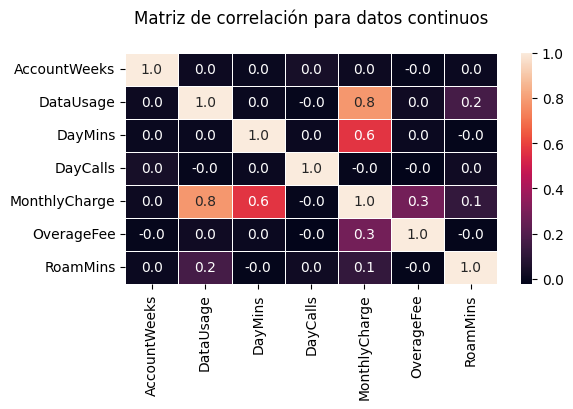

In [6]:
df_corr = df.drop(columns=['Churn', 'ContractRenewal', 'CustServCalls', 'DataPlan'])
df_corr = df_corr.corr()

fig, ax = plt.subplots(figsize=(6, 3))
ax.set_title('Matriz de correlación para datos continuos\n')
sns.heatmap(df_corr, annot=True, fmt=".1f", linewidths=0.5, ax=ax);


Se aprecian dos correlaciones importantes: Promedio de minutos diurnos al mes con la factura mensual media y Giga mensual de uso de datos también con factura mensual media. Ambas correlaciones son esperadas. Extrañamente se ve una correlación positiva baja entre la factura mensual media y la mayor cuota de exceso en los últimos 12 meses, sin embargo es la segunda correlación más alta con 0.3.

2. Desarrolla un modelo de árbol de decisión sin modificar sus hiper parámetros y despliega sus métricas de desempeño. Luego, mejora este modelo de forma de evitar el overfitting usando búsqueda por grilla con 5 kfold:

<center>max_depth: [5, 10, 15, 20, 25]</center>

<center>min_samples_split: [0.01, 0.02, 0.03, 0.04]</center>

> Da a conocer los mejores hiper parámetros encontrados y el desempeño del modelo, tanto en los datos de entrenamiento como en los de test.




In [7]:
RSTATE = 201235

X = df.drop(columns=['Churn'], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.33, random_state=RSTATE)
print(f'Train {X_train.shape}')
print(f'Test {X_test.shape}')


Train (1099, 10)
Test (2234, 10)


In [8]:
model0 = DecisionTreeClassifier(criterion='gini', random_state=RSTATE)
model0.fit(X_train, y_train)

yhat_train = model0.predict(X_train)
yhat_test = model0.predict(X_test)
print('Desempeño en datos de entrenamiento')
print(classification_report(y_train, yhat_train))

print('\nDesempeño en datos de test')
print(classification_report(y_test, yhat_test))


Desempeño en datos de entrenamiento
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       942
           1       1.00      1.00      1.00       157

    accuracy                           1.00      1099
   macro avg       1.00      1.00      1.00      1099
weighted avg       1.00      1.00      1.00      1099


Desempeño en datos de test
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1908
           1       0.70      0.63      0.66       326

    accuracy                           0.91      2234
   macro avg       0.82      0.79      0.81      2234
weighted avg       0.90      0.91      0.90      2234



In [9]:
%%time
model0 = DecisionTreeClassifier(criterion='gini', random_state=RSTATE, )
param_grid = {
    'max_depth': np.linspace(5, 25, 5, dtype='int'),
    'min_samples_split': np.linspace(0.01, 0.04, 4)
}
grid_model1 = GridSearchCV(
    DecisionTreeClassifier(random_state=RSTATE),
    param_grid=param_grid,
    n_jobs=-1,
    cv=5
)
grid_model1.fit(X_train, y_train)


CPU times: user 159 ms, sys: 60.7 ms, total: 220 ms
Wall time: 3.25 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=201235),
             n_jobs=-1,
             param_grid={'max_depth': array([ 5, 10, 15, 20, 25]),
                         'min_samples_split': array([0.01, 0.02, 0.03, 0.04])})

In [10]:
print(grid_model1.best_params_)
print(grid_model1.best_score_)


{'max_depth': 5, 'min_samples_split': 0.02}
0.9163138231631383


In [11]:
model1 = grid_model1.best_estimator_
model1.fit(X_train, y_train)

yhat_train = model1.predict(X_train)
yhat_test = model1.predict(X_test)
print('Desempeño en datos de entrenamiento')
print(classification_report(y_train, yhat_train))

print('\nDesempeño en datos de test')
print(classification_report(y_test, yhat_test))


Desempeño en datos de entrenamiento
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       942
           1       0.96      0.60      0.74       157

    accuracy                           0.94      1099
   macro avg       0.95      0.80      0.85      1099
weighted avg       0.94      0.94      0.93      1099


Desempeño en datos de test
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1908
           1       0.89      0.47      0.62       326

    accuracy                           0.91      2234
   macro avg       0.90      0.73      0.78      2234
weighted avg       0.91      0.91      0.90      2234



3. Balancea las clases usando SMOTE para el conjunto de entrenamiento. Luego, aplica un modelo de Bagging con 200 estimadores y muestra las métricas sobre el conjunto de test.

In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

y_train_resampled.value_counts()


0    942
1    942
Name: Churn, dtype: int64

In [13]:
# se entrena un modelo Bagging con 200 árboles

bagging_hom = BaggingClassifier(n_estimators=200)
bagging_hom.fit(X_train_resampled, y_train_resampled)

yhat_test = model1.predict(X_test)
print('\nDesempeño en datos de test')
print(classification_report(y_test, yhat_test))



Desempeño en datos de test
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1908
           1       0.89      0.47      0.62       326

    accuracy                           0.91      2234
   macro avg       0.90      0.73      0.78      2234
weighted avg       0.91      0.91      0.90      2234



4. Implementa un modelo de Bagging usando modelos heterogéneos con los siguientes estimadores: Regresión Logística, Árbol de decisión, y dos SVM de clasificación con kernel **rbf** y **sigmoid**. Para ello considera 200 muestras bootstrap (T).

> Debes calibrar la importancia de los modelos, repitiendo el modelo que sea más importante en la lista de modelos a entrenar. Considera que un mejor modelo es aquel con mejor f1-score. Muestra las métricas del modelo final aplicado al conjunto de test. (Para realizar esta tarea utiliza la función bagging_het que se encuentra en el archivo **util_bagging.py**)

In [14]:
import util_bagging as ubagging

###
# Ponderaciones
###

# LogisticRegression(max_iter=1000) -> 16.6%
# DecisionTreeClassifier()          -> 50.0%
# SVC(kernel='rbf', C=2.4)          -> 16.6%
# SVC(kernel='sigmoid', C=0.39)     -> 16.6%

estimators = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(),
    DecisionTreeClassifier(),
    DecisionTreeClassifier(),
    SVC(kernel='rbf', C=2.4),
    SVC(kernel='sigmoid', C=0.39)
]

trained_model, resultados, yhat, idx_oob = ubagging.bagging_het(X_train_resampled, y_train_resampled, 200, estimators, X_test)
print(classification_report(y_test, yhat))


              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1908
           1       0.63      0.75      0.68       326

    accuracy                           0.90      2234
   macro avg       0.79      0.84      0.81      2234
weighted avg       0.91      0.90      0.90      2234



5. Implementa un modelo de ensamble Random Forest usando como hiper parámetro **n_estimators = 45**. El modelo debe usar muestra OOB para estimar su ajuste ACCURACY, y debe mostrar las cuatro características más importantes junto con las métricas de desempeño en el conjunto de test.

In [15]:
model2 = RandomForestClassifier(n_estimators=45, oob_score=True, random_state=RSTATE, n_jobs=-1)
model2.fit(X_train, y_train)

yhat_test = model2.predict(X_test)
print(classification_report(y_test, yhat_test))


              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1908
           1       0.90      0.61      0.73       326

    accuracy                           0.93      2234
   macro avg       0.92      0.80      0.84      2234
weighted avg       0.93      0.93      0.93      2234



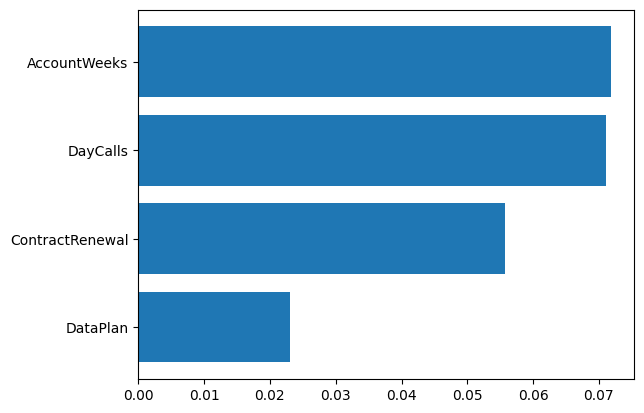

In [16]:
# visualizar importancia de los atributos del modelo
idx_sort = np.argsort(model2.feature_importances_)[:4]
plt.barh(y=model2.feature_names_in_[idx_sort], width=model2.feature_importances_[idx_sort]);


In [17]:
model2.oob_score_

0.9126478616924477

6. Realiza una búsqueda de grilla para un modelo Random Forest para los siguientes rangos de valores para sus hiper parámetros:
<center> <strong> n_estimators:</strong> 50 a 200 con paso de 10 </center>
<center><strong>max_features:</strong> [‘sqrt’, ‘log2’, None]</center>

Muestra los mejores hiper parámetros encontrados, la estimación de desempeño en los datos OOB, y despliega los cuatro atributos más importantes. ¿Tienen sentido estos? Analiza  además las métricas de desempeño,  ROC y AUC.


In [18]:
%%time
param_grid = {
    'n_estimators': np.linspace(50, 300, 25, dtype='int'),
    'max_features': ['sqrt', 'log2', None]
}
grid_model3 = GridSearchCV(
    RandomForestClassifier(oob_score=True, random_state=RSTATE),
    param_grid=param_grid,
    n_jobs=-1,
    cv=5
)
grid_model3.fit(X_train, y_train)


CPU times: user 2.48 s, sys: 322 ms, total: 2.81 s
Wall time: 3min 29s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True,
                                              random_state=201235),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2', None],
                         'n_estimators': array([ 50,  60,  70,  81,  91, 102, 112, 122, 133, 143, 154, 164, 175,
       185, 195, 206, 216, 227, 237, 247, 258, 268, 279, 289, 300])})

In [19]:
print(grid_model3.best_params_)
print(grid_model3.best_estimator_.oob_score_)


{'max_features': 'sqrt', 'n_estimators': 91}
0.916287534121929


In [20]:
model3 = grid_model3.best_estimator_

yhat_test = model3.predict(X_test)
print(classification_report(y_test, yhat_test))


              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1908
           1       0.90      0.61      0.73       326

    accuracy                           0.93      2234
   macro avg       0.92      0.80      0.84      2234
weighted avg       0.93      0.93      0.93      2234



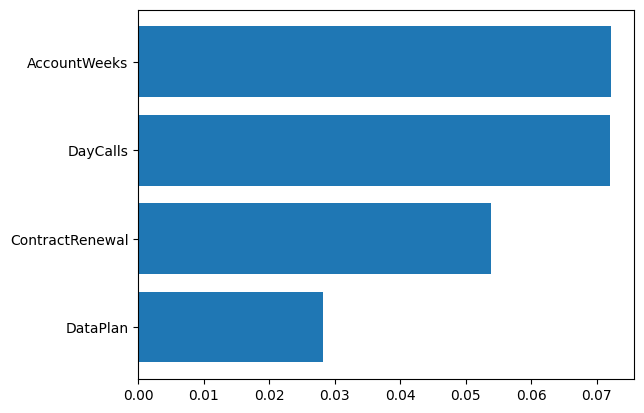

In [21]:
# visualizar importancia de los atributos del modelo
idx_sort = np.argsort(model3.feature_importances_)[:4]
plt.barh(y=model3.feature_names_in_[idx_sort], width=model3.feature_importances_[idx_sort]);


La interpretación de estos datos depende de los estudiantes. Se puede señalar que la cantidad de semanas puede explicar un cambio o no, ya sea fidelizando o provocando deseos de renunciar (probar algo nuevo). La cantidad de llamadas diarias aporta información sobre la experiencia de usuario. La renovación del contrato puede determinar si un cliente es más o menos proclive a cambiar (si ha renovado hace poco, no es muy razonable que quiera cambiar). El plan de datos aporta también a la experiencia de usuario.

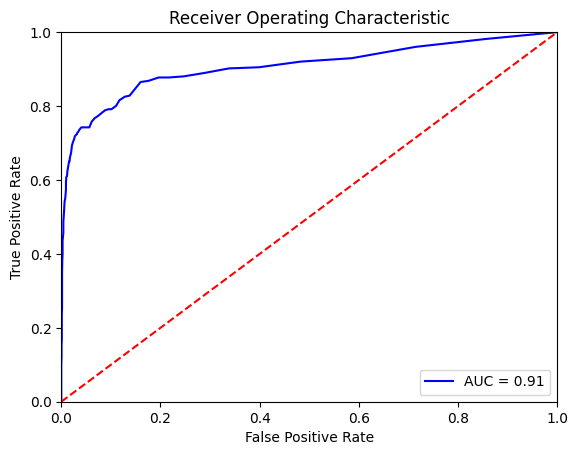

In [ ]:
yhat_proba_test = model3.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, yhat_proba_test[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


7. Usando el modelo Random Forest con sus hiper parámetros ajustados, muestre los 15 clientes que presentan la mayor propensión a renunciar.

In [ ]:
yhat_proba_test = model3.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, yhat_proba_test[:,1])
N = 15
yhat = model3.predict_proba(X)[:,1]
df_client = df.copy()
df_client['proba'] = yhat

sort_idx = np.argsort(yhat)[::-1]
df_client = df_client.iloc[sort_idx,]
df_client.head(N)


Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  \
521       1            88                1         0        0.0   
2099      1            71                1         0        0.0   
3072      1            75                1         0        0.0   
2708      1           132                1         0        0.0   
1078      1            80                1         0        0.0   
3132      1           161                1         0        0.0   
894       1            97                1         0        0.0   
975       1           129                1         0        0.0   
3272      1           133                1         0        0.0   
2415      1           114                1         0        0.0   
3169      1            78                1         0        0.4   
1538      1           113                1         0        0.0   
914       1           179                1         0        0.0   
126       1           162                1         0        0.0   
3112      1           115                1         0        0.0   

      CustServCalls  DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  \
521               4     73.3        86           27.0        8.07       8.2   
2099              3    290.4       108           71.0       12.70      10.1   
3072              0    305.1       106           68.0        9.40       8.5   
2708              1    291.2       104           70.0       11.71       8.9   
1078              0    322.3       113           74.0       11.10       6.7   
3132              2    322.3       100           75.0       11.52       7.8   
894               4    120.8        96           35.0        8.49      11.9   
975               0    334.3       118           74.0        9.61      10.4   
3272              2    295.0       141           70.0       11.18      12.9   
2415              5    147.1       119           39.0        8.05       9.0   
3169              4    103.5       115           32.0        5.90      12.0   
1538              5     61.2       111           19.0        4.62      13.7   
914               0    287.3       123           74.0       14.40      10.5   
126               4     70.7       108           26.0        7.88       9.1   
3112              7    139.3        89           41.0        9.62       9.3   

         proba  
521   1.000000  
2099  1.000000  
3072  0.989011  
2708  0.989011  
1078  0.989011  
3132  0.978022  
894   0.978022  
975   0.978022  
3272  0.978022  
2415  0.978022  
3169  0.978022  
1538  0.967033  
914   0.967033  
126   0.967033  
3112  0.967033